In [1]:
import json
import pandas as pd

from utils.plotter import plot_gantt_jobs
from utils.plotter import plot_gantt_machines
from utils.simple_priority_heuristics import schedule_spt

from utils.checker import check_machine_conflicts
from utils.checker import check_job_machine_sequence
from utils.checker import check_job_machine_sequence_dict

from utils.scheduler import generate_jobs_for_single_day
from utils.scheduler import solve_jobshop_optimal

In [2]:
import pulp
import pandas as pd


def solve_jobshop_optimal_scaled(job_dict, df_arrivals, day_id=0, solver_time_limit=300):
    # 1. Vorverarbeitung – Skalierung auf Hundertstel-Minuten (×100)
    job_names = list(job_dict.keys())
    num_jobs = len(job_names)

    scaled_job_dict = {
        job: [[m, int(round(d * 100))] for m, d in ops]
        for job, ops in job_dict.items()
    }
    all_ops = list(scaled_job_dict.values())

    arrival_times = df_arrivals.set_index("Job-ID")["Ankunftszeit (Minuten)"]\
        .apply(lambda x: int(round(x * 100))).to_dict()

    all_machines = {op[0] for job in all_ops for op in job}

    # 2. Modellaufbau
    prob = pulp.LpProblem("JobShop_Optimal_HiGHS_Scaled", pulp.LpMinimize)

    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0, cat="Integer")
        for j in range(num_jobs) for o in range(len(all_ops[j]))
    }

    makespan = pulp.LpVariable("makespan", lowBound=0, cat="Integer")
    prob += makespan

    # 3. Technologische Reihenfolge + Ankunftszeiten
    for j, job_name in enumerate(job_names):
        job = scaled_job_dict[job_name]
        prob += starts[(j, 0)] >= arrival_times[job_name]
        for o in range(1, len(job)):
            d_prev = job[o - 1][1]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev

    # 4. Maschinenkonflikte
    bigM = 10**6
    epsilon = 1  # Hundertstel-Minute Abstand

    for m in all_machines:
        ops = [(j, o, mach, d) for j in range(num_jobs)
               for o, (mach, d) in enumerate(all_ops[j]) if mach == m]

        for i in range(len(ops)):
            j1, o1, mach1, d1 = ops[i]
            for j2, o2, mach2, d2 in ops[i + 1:]:
                if j1 != j2:
                    y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                    prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                    prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # 5. Makespan-Bedingungen
    for j in range(num_jobs):
        last_op = len(all_ops[j]) - 1
        prob += makespan >= starts[(j, last_op)] + all_ops[j][last_op][1]

    # 6. Solve
    solver = pulp.HiGHS_CMD(msg=True, timeLimit=solver_time_limit)
    prob.solve(solver)

    # 7. Ergebnis zurückskalieren (÷100)
    schedule_data = []
    for (j, o), var in sorted(starts.items()):
        start = var.varValue
        if start is not None:
            machine, duration = all_ops[j][o]
            end = start + duration
            schedule_data.append({
                "Job": job_names[j],
                "Machine": f"M{machine}",
                "Day-ID": day_id,
                "Start": round(start / 100, 2),
                "Duration": round(duration / 100, 2),
                "End": round(end / 100, 2)
            })

    df_schedule = pd.DataFrame(schedule_data)
    makespan_value = round(pulp.value(makespan) / 100, 2)

    return df_schedule, makespan_value



In [3]:
import numpy as np
import random

In [4]:
# Datei laden
with open("data/jobshop_instances_named.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]

In [5]:
def print_jobs_compact(job_dict):
    for job, tasks in job_dict.items():
        print(f"{job}:\t{tasks}")

In [6]:
job_set_list = []

# Alle Jobs sortieren
sorted_job_names = sorted(instance, key=lambda x: int(x.split()[1]))

# Erzeuge 5 vollständige Varianten der Instanz mit umbenannten Jobs
for variant in range(5):
    job_dict = {}
    for original_index, job_name in enumerate(sorted_job_names):
        new_name = f"Job {variant:02d}_{original_index}"  # z. B. job 00_0, job 01_4, ...
        job_dict[new_name] = instance[job_name]
    job_set_list.append(job_dict)

In [7]:
# Beispielausgabe
for idx, job_set in list(enumerate(job_set_list))[:3]:
    print(f"\n--- Jobset {idx} ---")
    print_jobs_compact(job_set)


--- Jobset 0 ---
Job 00_0:	[[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job 00_1:	[[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job 00_2:	[[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job 00_3:	[[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job 00_4:	[[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job 00_5:	[[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job 00_6:	[[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job 00_7:	[[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job 00_8:	[[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job 00_9:	[[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 5

## I) First Day

In [9]:
day_0 = job_set_list[0]

### a) Ankunftszeiten

In [11]:
df_arrivals_first_day = generate_jobs_for_single_day(day_0, day_id= 0)
df_arrivals_first_day

,Job-ID,Day-ID,Ankunftszeit (Minuten)
0,Job 00_5,0,83.59
1,Job 00_8,0,107.22
2,Job 00_7,0,125.26
3,Job 00_0,0,181.45
4,Job 00_4,0,270.56
5,Job 00_9,0,309.13
6,Job 00_3,0,586.13
7,Job 00_2,0,667.09
8,Job 00_1,0,713.06
9,Job 00_6,0,747.96


### b) Scheduling - HiGHS

In [13]:
df_schedule_highs, opt_makespan = solve_jobshop_optimal(day_0, df_arrivals_first_day)
print(f"Optimaler Makespan: {opt_makespan} Zeiteinheiten")

Optimaler Makespan: 1346.13 Zeiteinheiten


In [14]:
df_schedule_highs

,Job,Machine,Day-ID,Start,Duration,End
0,Job 00_0,M0,0,410.6,29,439.6
1,Job 00_0,M1,0,443.6,78,521.6
2,Job 00_0,M2,0,658.1,9,667.1
3,Job 00_0,M3,0,728.1,36,764.1
4,Job 00_0,M4,0,808.2,49,857.2
...,...,...,...,...,...,...
95,Job 00_9,M9,0,543.2,76,619.2
96,Job 00_9,M5,0,619.2,47,666.2
97,Job 00_9,M3,0,666.2,52,718.2
98,Job 00_9,M4,0,718.2,90,808.2


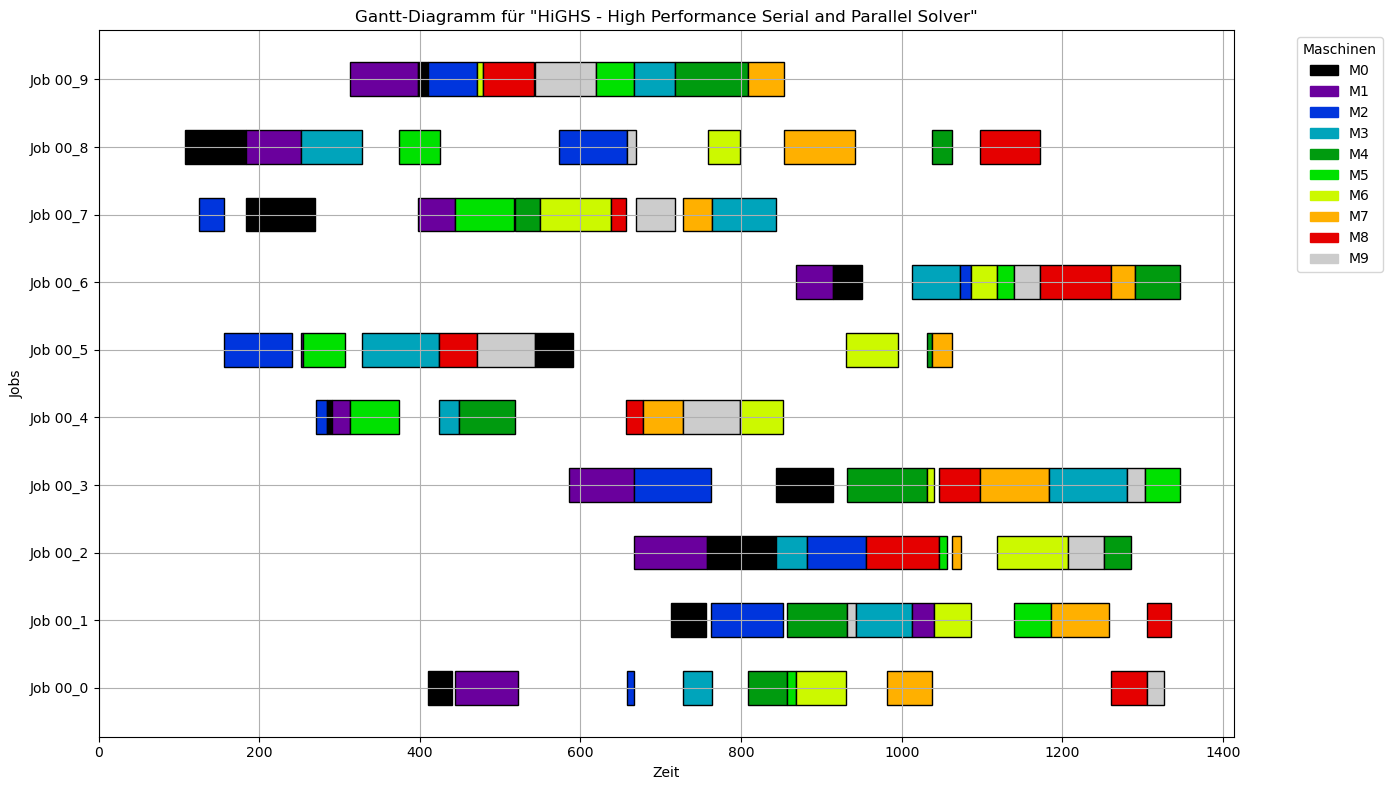

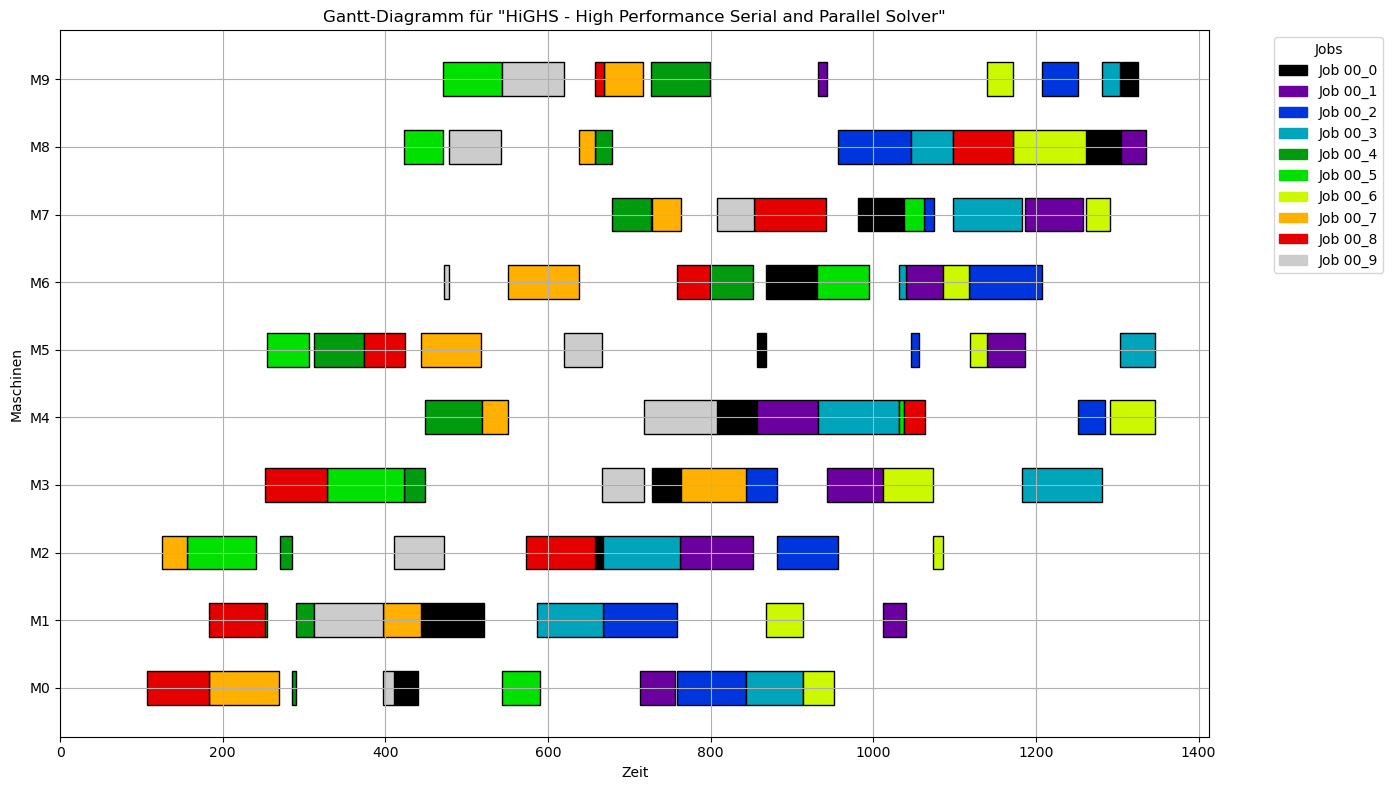

In [15]:
df = df_schedule_highs
category = "HiGHS - High Performance Serial and Parallel Solver"

plot_gantt_jobs(df, 'Gantt-Diagramm für "{}"'.format(category))
plot_gantt_machines(df, 'Gantt-Diagramm für "{}"'.format(category))

In [16]:
check_machine_conflicts(df_schedule_highs)
check_job_machine_sequence_dict(df_schedule_highs, day_0)

Gefundene Konflikte auf Maschinen: 0

Anzahl verletzter Job-Maschinen-Reihenfolgen: 0


True

In [17]:
max(df_schedule_highs.End)

1346.1

### c) Tageslimit

In [19]:
def get_operations_ending_after_day_limit(df: pd.DataFrame, daily_timelimit_h: float) -> pd.DataFrame:
    daily_timelimit = daily_timelimit_h * 60  # Umrechnung in Minuten
    return df[df["End"] > daily_timelimit].copy()
    
df_late = get_operations_ending_after_day_limit(df_schedule_highs, 21)
df_late

,Job,Machine,Day-ID,Start,Duration,End
8,Job 00_0,M8,0,1261.1,44,1305.1
9,Job 00_0,M9,0,1305.1,21,1326.1
19,Job 00_1,M8,0,1305.1,30,1335.1
29,Job 00_2,M4,0,1252.2,33,1285.2
37,Job 00_3,M3,0,1183.1,98,1281.1
38,Job 00_3,M9,0,1281.1,22,1303.1
39,Job 00_3,M5,0,1303.1,43,1346.1
67,Job 00_6,M8,0,1172.1,89,1261.1
68,Job 00_6,M7,0,1261.1,30,1291.1
69,Job 00_6,M4,0,1291.1,55,1346.1


In [20]:
def get_jssp_from_schedule(df_schedule: pd.DataFrame, num_machines: int = 10) -> dict:
    job_dict = {}

    df_schedule = df_schedule.copy()
    df_schedule["Machine"] = df_schedule["Machine"].str.extract(r"M(\d+)").astype(int)
    df_schedule["Duration"] = df_schedule["Duration"].astype(int)

    for job_name, group in df_schedule.groupby("Job"):
        group_sorted = group.sort_values("Start")  # technologische Reihenfolge erhalten
        operations = group_sorted[["Machine", "Duration"]].values.tolist()

        used_machines = [op[0] for op in operations]
        used_machines_set = set(used_machines)

        # Fehlende Maschinen ergänzen (hinten anhängen, Dauer 0) # DUMMY 
        for m in range(num_machines):
            if m not in used_machines_set:
                operations.append([m, 0])  # Dummy-Operation

        job_dict[job_name] = operations

    return job_dict

def get_jssp_from_schedule(df_schedule: pd.DataFrame) -> dict:
    job_dict = {}

    df_schedule = df_schedule.copy()
    df_schedule["Machine"] = df_schedule["Machine"].str.extract(r"M(\d+)").astype(int)
    df_schedule["Duration"] = df_schedule["Duration"].astype(int)

    for job_name, group in df_schedule.groupby("Job"):
        group_sorted = group.sort_values("Start")  # technologische Reihenfolge erhalten
        operations = group_sorted[["Machine", "Duration"]].values.tolist()

        job_dict[job_name] = operations

    return job_dict



jssp_instance = get_jssp_from_schedule(df_late)
print_jobs_compact(jssp_instance)

Job 00_0:	[[8, 44], [9, 21]]
Job 00_1:	[[8, 30]]
Job 00_2:	[[4, 33]]
Job 00_3:	[[3, 98], [9, 22], [5, 43]]
Job 00_6:	[[8, 89], [7, 30], [4, 55]]


## II) Second Day

In [22]:
day_1 = job_set_list[1]
print_jobs_compact(day_1)

Job 01_0:	[[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job 01_1:	[[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job 01_2:	[[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job 01_3:	[[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job 01_4:	[[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job 01_5:	[[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job 01_6:	[[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job 01_7:	[[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job 01_8:	[[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job 01_9:	[[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 4

### merge

In [24]:
def merge_jssp_jobs(new_jobs: dict, remained_jobs: dict) -> dict:
    # Kombiniere beide Dictionaries
    merged = {**remained_jobs, **new_jobs}
    return merged 

day_1_extended = merge_jssp_jobs(day_1, jssp_instance)
print_jobs_compact(day_1_extended)

Job 00_0:	[[8, 44], [9, 21]]
Job 00_1:	[[8, 30]]
Job 00_2:	[[4, 33]]
Job 00_3:	[[3, 98], [9, 22], [5, 43]]
Job 00_6:	[[8, 89], [7, 30], [4, 55]]
Job 01_0:	[[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job 01_1:	[[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job 01_2:	[[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job 01_3:	[[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job 01_4:	[[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job 01_5:	[[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job 01_6:	[[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job 01_7:	[[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job 01_8:	[[0, 76], [1, 69], [3, 76], [5, 51], [2, 8

### Zwischenankuftszeiten!!! (erst ohne merge)

In [26]:
df_arrivals = generate_jobs_for_single_day(day_1, day_id = 1)
df_arrivals

,Job-ID,Day-ID,Ankunftszeit (Minuten)
0,Job 01_5,1,83.59
1,Job 01_8,1,107.22
2,Job 01_7,1,125.26
3,Job 01_0,1,181.45
4,Job 01_4,1,270.56
5,Job 01_9,1,309.13
6,Job 01_3,1,586.13
7,Job 01_2,1,667.09
8,Job 01_1,1,713.06
9,Job 01_6,1,747.96


In [27]:
def add_remaining_jobs_with_zero_arrival(df_arrivals_new: pd.DataFrame, remaining_jobs: dict, day_id: int) -> pd.DataFrame:
    job_names = list(remaining_jobs.keys())

    df_remaining = pd.DataFrame({
        "Job-ID": job_names,
        "Day-ID": [day_id] * len(job_names),
        "Ankunftszeit (Minuten)": [0.0] * len(job_names)
    })
    
    return pd.concat([df_remaining, df_arrivals_new], ignore_index=True)



df_arrivals = add_remaining_jobs_with_zero_arrival(df_arrivals, jssp_instance, day_id=1)
df_arrivals

,Job-ID,Day-ID,Ankunftszeit (Minuten)
0,Job 00_0,1,0.00
1,Job 00_1,1,0.00
2,Job 00_2,1,0.00
3,Job 00_3,1,0.00
4,Job 00_6,1,0.00
5,Job 01_5,1,83.59
6,Job 01_8,1,107.22
7,Job 01_7,1,125.26
8,Job 01_0,1,181.45
9,Job 01_4,1,270.56


### Scheduling

In [29]:
df_schedule_highs, opt_makespan = solve_jobshop_optimal(day_1_extended, df_arrivals)
print(f"Optimaler Makespan: {opt_makespan} Zeiteinheiten")

Optimaler Makespan: 1346.13 Zeiteinheiten


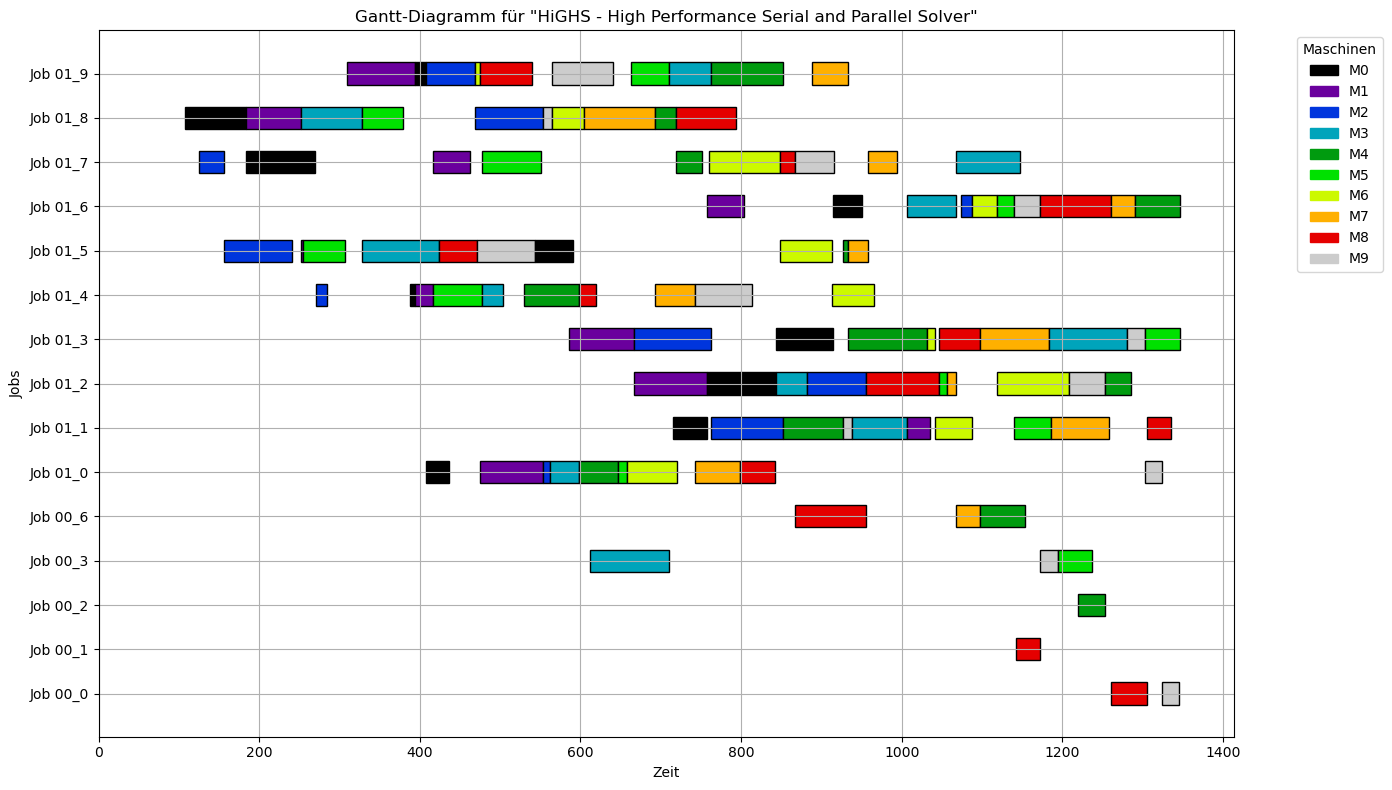

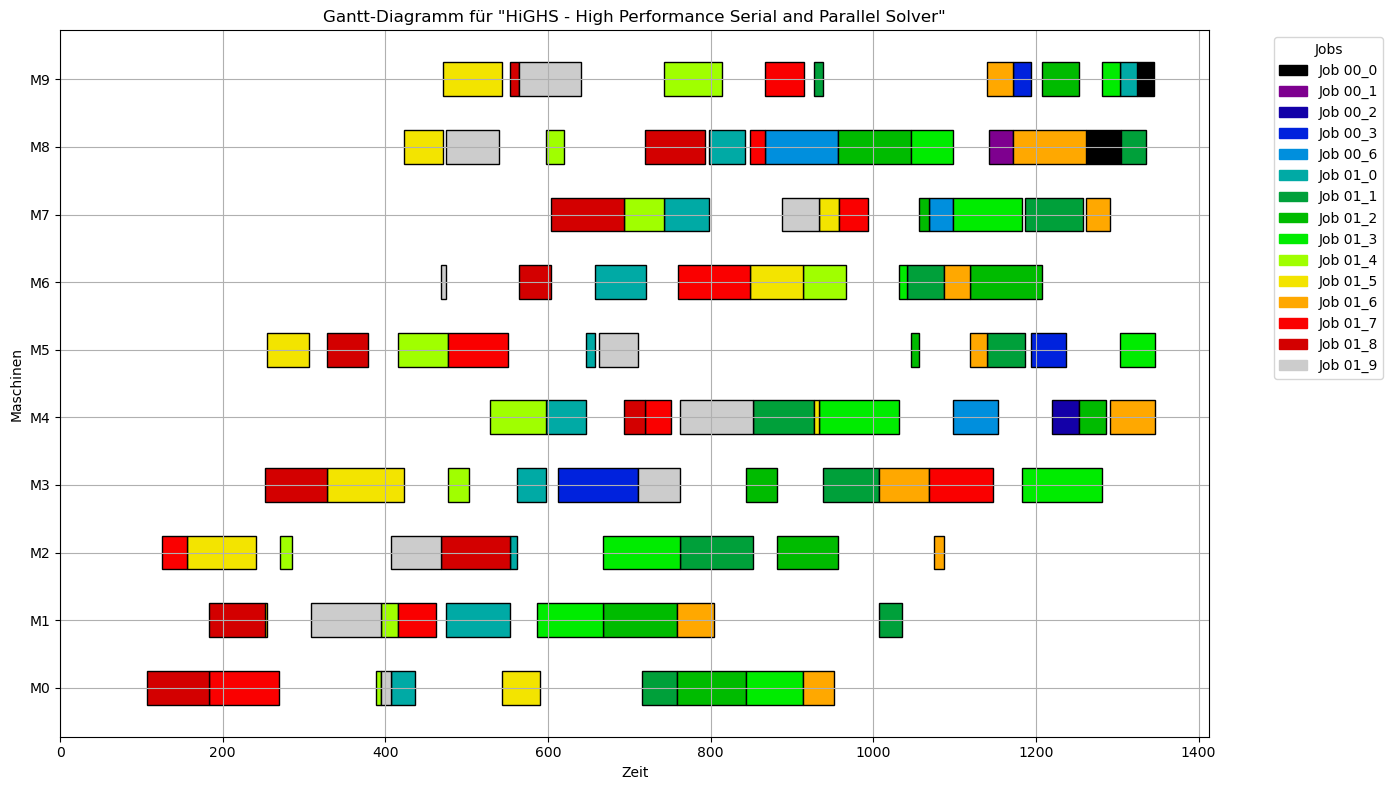

In [30]:
df = df_schedule_highs
category = "HiGHS - High Performance Serial and Parallel Solver"

plot_gantt_jobs(df, 'Gantt-Diagramm für "{}"'.format(category))
plot_gantt_machines(df, 'Gantt-Diagramm für "{}"'.format(category))

In [31]:
check_machine_conflicts(df_schedule_highs)
check_job_machine_sequence_dict(df_schedule_highs, day_1_extended)

Gefundene Konflikte auf Maschinen: 0

Anzahl verletzter Job-Maschinen-Reihenfolgen: 0


True

In [32]:
def check_machine_conflicts(df_schedule: pd.DataFrame) -> int:
    df = df_schedule.copy()
    df["Machine_ID"] = df["Machine"].str.extract(r"M(\d+)").astype(int)

    conflict_count = 0
    conflicted_machines = []

    for machine in sorted(df["Machine_ID"].unique()):
        machine_df = df[df["Machine_ID"] == machine].sort_values("Start")

        for i in range(1, len(machine_df)):
            prev_end = machine_df.iloc[i - 1]["End"]
            current_start = machine_df.iloc[i]["Start"]

            if current_start < prev_end:
                conflict_count += 1
                conflicted_machines.append(machine)
                break  # pro Maschine nur 1x zählen

    if conflict_count > 0:
        print(f"⚠️  Gefundene Konflikte auf Maschinen: {sorted(set(conflicted_machines))}")
    else:
        print("✅ Keine Maschinenkonflikte gefunden.")

    return conflict_count
check_machine_conflicts(df_schedule_highs)


✅ Keine Maschinenkonflikte gefunden.


0

### Export

In [34]:
# Nach Startzeit sortieren
df_schedule_highs = df_schedule_highs.sort_values(by="Start").reset_index(drop=True)
df_schedule_highs

,Job,Machine,Day-ID,Start,Duration,End
0,Job 01_8,M0,0,107.2,76,183.2
1,Job 01_7,M2,0,125.3,31,156.3
2,Job 01_5,M2,0,156.3,84,240.3
3,Job 01_7,M0,0,183.2,86,269.2
4,Job 01_8,M1,0,183.2,69,252.2
...,...,...,...,...,...,...
105,Job 01_6,M4,0,1291.1,55,1346.1
106,Job 01_0,M9,0,1303.1,21,1324.1
107,Job 01_3,M5,0,1303.1,43,1346.1
108,Job 01_1,M8,0,1305.1,30,1335.1


In [35]:
df_schedule_highs.to_csv("output/schedule_day0.csv", index = False)